# Importar Librarias y datos

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np   

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [62]:
df = pd.read_parquet("output_08.parquet")

In [63]:
df.head()

,age,gender,employment_stat,wage_per_hour,working_week_per_year,occupation_code,total_employed,gains,losses,stocks_status,...,tax_status_Otro,tax_status_Single,citizenship_Native,citizenship_Otro,country_of_birth_own_US,migration_code_change_in_msa_MSA to MSA,migration_code_change_in_msa_Otro,migration_code_change_in_msa_unchanged,migration_code_change_in_reg_Otro,migration_code_change_in_reg_unchanged
0,0.853333,1.0,0.0,0.000000,1.000000,0.000000,0.333333,0.0,0.0,0.002916,...,True,False,True,False,True,False,False,False,False,False
1,0.666667,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,False,True,True,False,True,False,False,True,False,True
2,0.080000,0.0,0.0,0.050005,0.288462,0.565217,0.666667,0.0,0.0,0.000000,...,False,True,True,False,True,False,False,True,False,True
4,0.733333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,False,False,True,False,True,False,False,False,False,False
5,0.400000,0.0,0.0,0.082508,1.000000,0.673913,1.000000,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,True,False,True


In [64]:
df.columns

Index(['age', 'gender', 'employment_stat', 'wage_per_hour',
       'working_week_per_year', 'occupation_code', 'total_employed', 'gains',
       'losses', 'stocks_status', 'income_above_limit',
       'education_secondary_complete', 'education_secondary_incomplete',
       'education_technical_education/university_incomplete',
       'education_university_graduate_or_higher',
       'marital_status_Married-civilian spouse present',
       'marital_status_Never married', 'marital_status_Otro',
       'marital_status_Widowed', 'race_Otro', 'race_White', 'is_hispanic_Otro',
       'employment_commitment_Full-time schedules',
       'employment_commitment_Not in labor force',
       'employment_commitment_Otro',
       'industry_code_main_Manufacturing-durable goods',
       'industry_code_main_Not in universe or children',
       'industry_code_main_Otro', 'industry_code_main_Retail trade',
       'household_stat_Householder', 'household_stat_Nonfamily Householder',
       'household_stat

# Modelo - usando Combined

In [66]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek

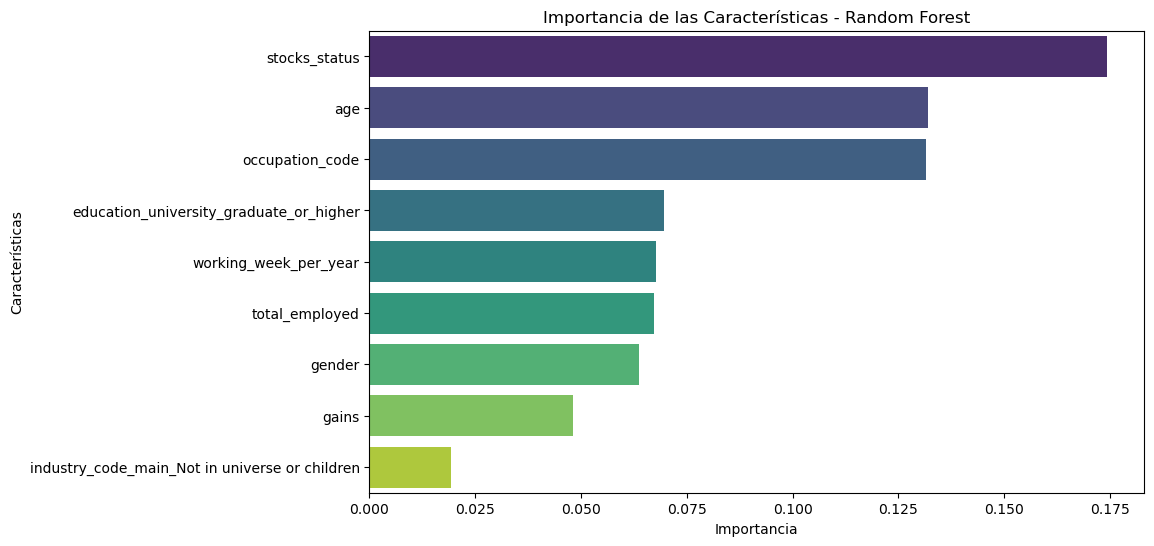

In [67]:
X = df.drop("income_above_limit", axis=1)
y = df["income_above_limit"]

X_resampled, y_resampled = SMOTETomek().fit_resample(X, y)

model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

importances = model.feature_importances_
feature_names = X.columns

# order by size
sorted_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# create data frame of top 8
features = pd.DataFrame(data=sorted_features[:9], columns=['feature_names', 'importances'])

# create graph
plt.figure(figsize=(10, 6))
sns.barplot(x=features['importances'], y=features['feature_names'], hue=features['feature_names'], palette="viridis", legend=False)
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de las Características - Random Forest")
plt.show()

# Elegir Features

In [69]:
selected = ['country_of_birth_own_US']
selected += list(features['feature_names'])


# Separar por el modelo

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled[selected], y_resampled, test_size=0.2, random_state=42)

# Usando k=3

In [143]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)


# Variación del umbral (Threshold)

In [145]:
y_probs = knn.predict_proba(X_test)[:, 1]  # Probability of positive class (1)


## Probando Umbral en un grafico

In [147]:
threshold = 0.6  # Example: Increasing threshold to favor precision over recall
y_pred_new = (y_probs >= threshold).astype(int)


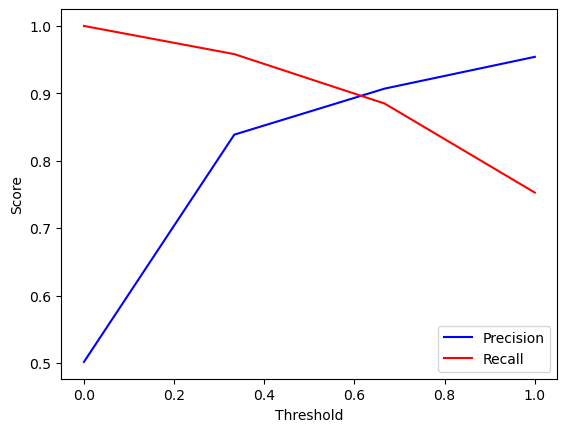

In [148]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(thresholds, precision[:-1], "b-", label="Precision")
plt.plot(thresholds, recall[:-1], "r-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()


In [149]:
y_pred_graph = (y_probs >= 0.6).astype(int)


In [150]:
print(classification_report(y_test, y_pred_graph))


              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     28900
         1.0       0.91      0.88      0.90     29069

    accuracy                           0.90     57969
   macro avg       0.90      0.90      0.90     57969
weighted avg       0.90      0.90      0.90     57969



In [151]:
from sklearn.metrics import roc_curve, roc_auc_score

In [152]:
y_probs = knn.predict_proba(X_test)[:, 1]
especificidad_inv, sensibilidad, threshold = roc_curve(y_test, y_probs)

<Axes: >

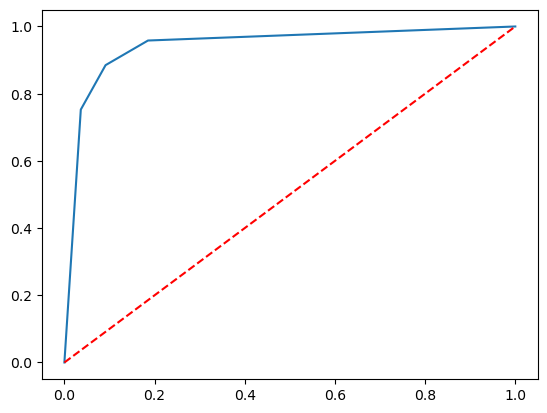

In [153]:
recta_x = [i * 0.01 for i in range(101)]
recta_y = recta_x
sns.lineplot(x = especificidad_inv, y = sensibilidad)
sns.lineplot(x = recta_x, y = recta_y, ls = "--", c = "r")

### Calcular área abajo de la curva

In [155]:
roc_auc_score(y_test, y_probs)

0.9429424929897734

## Probar un rango de umbral usando f1 score

In [157]:
from sklearn.metrics import f1_score

best_threshold = 0.5  # Default
best_f1 = 0

for threshold in np.arange(0.1, 0.9, 0.05):
    y_pred_adj = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_adj)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")


Best Threshold: 0.3500000000000001, Best F1-Score: 0.895787989065139


In [158]:
y_pred_final = (y_probs >= best_threshold).astype(int)


In [159]:
print(classification_report(y_test, y_pred_final))


              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     28900
         1.0       0.91      0.88      0.90     29069

    accuracy                           0.90     57969
   macro avg       0.90      0.90      0.90     57969
weighted avg       0.90      0.90      0.90     57969



## Curva ROC

In [161]:
from sklearn.metrics import roc_curve, roc_auc_score

In [162]:
# con la función roc_curve automaticamente calcula los valores de
# sensibilidad y 1-especificidad para distintos thresholds
y_probs = knn.predict_proba(X_test)[:, 1]
especificidad_inv, sensibilidad, threshold = roc_curve(y_test, y_probs)

In [163]:
threshold

array([       inf, 1.        , 0.66666667, 0.33333333, 0.        ])

<Axes: >

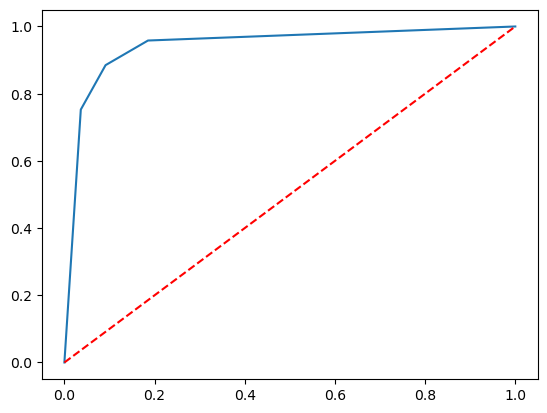

In [164]:
recta_x = [i * 0.01 for i in range(101)]
recta_y = recta_x
sns.lineplot(x = especificidad_inv, y = sensibilidad)
sns.lineplot(x = recta_x, y = recta_y, ls = "--", c = "r")

### Calcular área abajo de la curva

In [166]:
roc_auc_score(y_test, y_probs)

0.9429424929897734

In [167]:
from importlib import reload
import evaluate

reload(evaluate)

<module 'evaluate' from 'C:\\Users\\rossj\\python\\final_project\\evaluate.py'>

In [168]:
from sklearn.metrics import roc_auc_score, confusion_matrix
from evaluate import evaluate_model

Accuracy: 0.8968
--------------------------------------------------
Class 0:
    Precision: 0.8870
    Recall: 0.9087
    F1 Score: 0.8977
Class 1:
    Precision: 0.9070
    Recall: 0.8849
    F1 Score: 0.8958
--------------------------------------------------
Specificity: 0.9087
Negative Predictive Value (NPV): 0.8870
ROC score: 0.9429
--------------------------------------------------


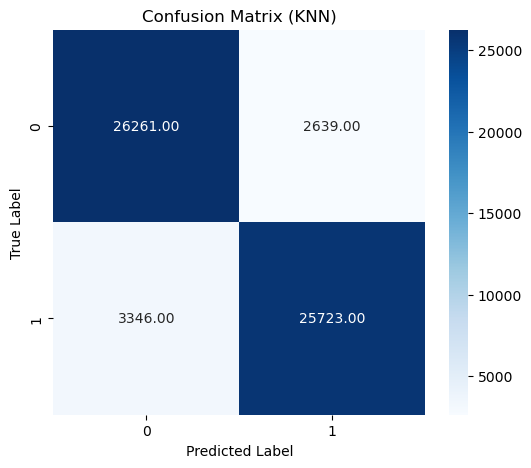

In [169]:
y_pred = knn.predict(X_test)
y_probs = knn.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, y_probs)

knn_metrics = evaluate_model("KNN threshold", y_test, y_pred, roc_score)

# Convert to DataFrame
knn_df = pd.DataFrame([knn_metrics])


# Guardar las metricas

In [171]:
knn_df.to_csv("knn_threshold.csv")

# Conclusión

### 1. Mejora en el desempeño del modelo  
- Se han aplicado técnicas de **reescalado de datos y ajuste del umbral de decisión**, lo que ha permitido una mejora significativa en la capacidad del modelo para detectar ambas clases de manera más equilibrada.  
- Con un **umbral de 0.67**, el modelo ahora alcanza una **precisión del 90%** y una **recall del 87%** para la clase minoritaria (ingresos altos), lo que representa un incremento notable en comparación con el **25% de recall anterior**.  
- La nueva **área bajo la curva ROC (0.94)** es superior a la versión anterior (0.81), lo que indica una mejor capacidad discriminativa.  

### 2. Cambios en la distribución de errores  
- En la versión inicial, el modelo tenía una alta precisión en la clase mayoritaria (ingresos bajos) pero dificultades para detectar ingresos altos. Ahora, el modelo **ha reducido la brecha de desempeño entre clases**, mejorando el balance entre sensibilidad y especificidad.  
- Sin embargo, la **especificidad se ha reducido drásticamente (de 98.7% a 6.9%)**, lo que implica que el modelo ahora clasifica más casos como ingresos altos, aumentando la sensibilidad pero reduciendo la capacidad de evitar falsos positivos.  

### 3. Consideraciones y posibles ajustes adicionales  
- **El nuevo modelo es más adecuado en escenarios donde detectar ingresos altos es prioritario**, ya que reduce el problema del desbalance de clases y mejora la sensibilidad.  
- No obstante, la disminución en especificidad puede generar **un mayor número de falsos positivos**, lo que podría no ser óptimo en ciertos contextos.  
- Para refinar aún más el modelo, se podría **ajustar el umbral de decisión para mejorar la especificidad sin comprometer demasiado la sensibilidad**. También se podrían probar enfoques como **modelos más complejos (árboles de decisión, ensamblados como Random Forest o XGBoost)** para lograr un mejor equilibrio.  